---

# InClass Kaggle Competition - Example - Python - v5.3

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 22/03/2022

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

In [2]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_all_v5.3
Wall time: 0 ns


In [3]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

Wall time: 0 ns


## Initiation

In [4]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV,cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

Wall time: 5.17 s


In [5]:
def benchmark(models,model_name,X_train,y_train,cv):
    
    measures = pd.DataFrame()
    AUC_test = []
    AUC_train = []
    Score_test = []
    Score_train =[]

    for model,name in zip(models,model_name): 
        AUC_v = cross_validate(model, X_train, y_train, scoring='roc_auc', cv=cv,return_train_score=True)
        AUC_test=AUC_v["test_score"].mean()
        AUC_train=AUC_v["train_score"].mean()
        Score_v = cross_validate(model, X_train, y_train, scoring='accuracy', cv=cv,return_train_score=True)
        Score_test=Score_v["test_score"].mean()
        Score_train=Score_v["train_score"].mean()
        measures[name] = [AUC_test, Score_test,AUC_train,Score_train]
        measures.index =['Test AUC Score', 'Test accuracy score','Train AUC Score', 'Train accuracy score']
    return measures

## 1. Data summary

#### (a) Read and print out some data

In [6]:
%%time
# Read train, test
train = pd.read_csv('./data/processed/g1/bank_mkt_train.csv', low_memory=False)
test = pd.read_csv('./data/processed/g1/bank_mkt_test.csv', low_memory=False)

Wall time: 113 ms


In [7]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

object     10
float64     9
int64       2
dtype: int64
Wall time: 3 ms


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [8]:
%%time
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

Wall time: 0 ns


#### (c) Check the target variable class distribution

In [9]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64
Wall time: 11.8 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables


In [10]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Wall time: 32.5 ms


#### (b) Check and correct data error - Missing values

In [11]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1730
Train - # NA of cat vars: 1934
Test - # NA of num vars: 918
Test - # NA of cat vars: 1057
Wall time: 26.3 ms


In [12]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
Wall time: 15 ms


In [13]:
%%time

na_vars = []
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

Wall time: 35 ms


In [14]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

Wall time: 30.1 ms


#### (c) Check and correct data error - Outliers in numerical variables

In [15]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

age has # outliers on train, test : 181 [ 0.9 % ] 89 [ 0.89 % ]
campaign has # outliers on train, test : 423 [ 2.11 % ] 210 [ 2.1 % ]
pdays has # outliers on train, test : 750 [ 3.75 % ] 371 [ 3.71 % ]
previous has # outliers on train, test : 519 [ 2.6 % ] 269 [ 2.69 % ]
Wall time: 29.6 ms


#### (d) Encode categorical variables

In [16]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [17]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

Wall time: 236 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

In [18]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

Wall time: 46.7 ms


In [19]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']
Wall time: 1 ms


In [20]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 30)
(10000, 29)
Wall time: 7.08 ms


### 2.2. Feature engineering

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [21]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.235584
cons.conf.idx    0.055546
age              0.034892
Name: subscribe, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.137655
emp.var.rate     -0.298583
euribor3m        -0.307895
pdays            -0.332565
nr.employed      -0.354529
Name: subscribe, dtype: float64
Wall time: 13 ms


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [22]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names_out()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49299075190162284 --> 0.5908793357880742
Wall time: 7.98 s


### 2.3. Value transformation (num, cat => cat)

#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Apply the variable remmaping for all categorical variables

In [23]:
%%time
# List of variables to track the value transformation process
trans_vars = []

if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 13 to 11 categories
Remapping variable marital from 5 to 3 categories
Remapping variable education from 9 to 7 categories
Remapping variable default from 4 to 3 categories
Remapping variable housing from 4 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 9 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories
Wall time: 2.83 s


#### 2.3.2. Discretizing (or binning) numerical variables - Equal frequency discretization

#### (a) Apply the variable discretizing for all numerical variables

In [24]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

Wall time: 218 ms


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessi

#### 2.3.3. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [25]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 19
Wall time: 962 µs


In [26]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 51)
(10000, 50)
Wall time: 18.6 ms


### 2.4. Value representation (cat => num)


In [27]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

Wall time: 0 ns


#### 2.4.1. Dummy coding

#### (a) Apply the value representation for all categorical variables

In [28]:
%%time
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names_out().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

Wall time: 187 ms


#### 2.4.2. Incidence (of target variable) replacement

#### (a) Apply the value representation for all categorical variables

In [29]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

Wall time: 1.16 s


#### 2.4.3. Weight-of-Evidence (WoE) conversion

#### (a) Apply the value representation for all categorical variables

In [30]:
%%time
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

Wall time: 1.17 s


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

In [31]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

Wall time: 38.8 ms


In [32]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

Wall time: 92.2 ms


#### (b) Impute missing values created by value representation

In [33]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

Wall time: 214 ms


#### (c) Finalize the variables list

In [34]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 208
Wall time: 0 ns


In [35]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + na_vars + target_var]
test = test[id_var + num_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 230)
(10000, 229)
Wall time: 27.7 ms


### 2.5. Other data processing

####  (a) Filter out again low variance variables (or constant)

In [36]:
%%time
# List of all predictors
predictors = num_vars + na_vars

Wall time: 0 ns


In [37]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
Wall time: 125 ms


####  (b) scale numeric variables

In [38]:
##### (a) Data normalization - Numerical variables
%time
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

Wall time: 0 ns


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [39]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 53
Wall time: 4.22 s


In [40]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

Wall time: 24.8 ms


#### (d) Export the processed data to file

In [41]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 177)
(10000, 176)
Wall time: 621 µs


In [42]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/final/" + fname + ".pkl")
test.to_pickle("./data/processed/final/" + fname + ".pkl")

Wall time: 55.7 ms


### 2.6. Variable selection

####  (a) Variable selection: Fisher Score

In [43]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [44]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head(50)

Wall time: 455 ms


,predictor,fisherscore
8,nr.employed,0.738579
7,euribor3m,0.701092
4,emp.var.rate,0.669549
87,emp.var.rate_binef_4.0,0.596566
2,pdays,0.465701
63,poutcome_3.0,0.448828
115,nr.employed_binef_4.0,0.412251
3,previous,0.385756
83,previous_binef_1.0,0.383010
62,poutcome_2.0,0.373415


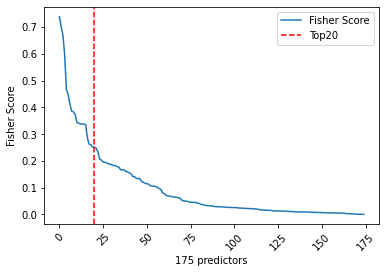

Wall time: 437 ms


In [45]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

In [46]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
measures = pd.DataFrame()
for s,i in zip(fs_scores,range(1, top_n_vars+1)):
    train_score= s['train_score'].mean()
    test_score=s['test_score'].mean()
    measures[i] = [train_score, test_score]
    measures.index =['Train AUC Score', 'Test AUC score']


Wall time: 20.3 s


In [47]:
measures

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
Train AUC Score,0.746509,0.748537,0.755055,0.749795,0.756286,0.756386,0.773060,0.777387,0.777918,0.778150,...,0.795144,0.795334,0.795140,0.795574,0.796075,0.796081,0.796044,0.796179,0.796358,0.796381
Test AUC score,0.746588,0.749822,0.755051,0.749947,0.756203,0.756380,0.773075,0.776225,0.777440,0.777517,...,0.791440,0.791622,0.790953,0.791451,0.791542,0.791422,0.791463,0.791467,0.791528,0.791506


In [48]:
%%time
# Select the top variables based on Fisher Score
top_fs_vars = fs_df['predictor'].values[:top_n_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50
Wall time: 874 µs


array(['nr.employed', 'euribor3m', 'emp.var.rate',
       'emp.var.rate_binef_4.0', 'pdays', 'poutcome_3.0',
       'nr.employed_binef_4.0', 'previous', 'previous_binef_1.0',
       'poutcome_2.0', 'emp.var.rate_binef_2.0', 'contact_2.0',
       'cons.conf.idx_binef_5.0', 'cons.conf.idx_binef_6.0',
       'nr.employed_binef_3.0', 'contact_1.0', 'cons.price.idx',
       'euribor3m_binef_5.0', 'nr.employed_binef_1.0', 'default_remap_4',
       'default_2.0', 'month_7.0', 'default_1.0',
       'cons.conf.idx_binef_7.0', 'month_9.0', 'month_6.0', 'month_10.0',
       'euribor3m_binef_8.0', 'cons.price.idx_binef_4.0',
       'cons.price.idx_binef_5.0', 'euribor3m_binef_4.0', 'job_2.0',
       'cons.price.idx_binef_2.0', 'cons.conf.idx_binef_2.0',
       'cons.price.idx_binef_6.0', 'job_6.0', 'age_binef_9.0', 'campaign',
       'emp.var.rate_binef_1.0', 'euribor3m_binef_9.0', 'age^3',
       'job_9.0', 'campaign_binef_3.0', 'cons.conf.idx_binef_3.0',
       'euribor3m_binef_7.0', 'month_1.0'

## 3. Modeling

<u>Note:</u>
- Mass feature engineering may lead to overfitting. Especially with the techniques that link information from the target variable to the predictors (including Fisher Score for variable selection).
- Therefore, the k-fold cross-validation in below is convenient to use, but is not a 100% correct method to estimate the performance of the models. Train, validation and test set should be processed separately to avoid information leakage.

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [49]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

Wall time: 0 ns


In [50]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE SET #
#########################################################
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs

# Prepare the data according to the selected set of variables
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 50)
_full_fs50_v5.3
Wall time: 7.51 ms


### 3.1. Modeling

In [51]:
lr = LogisticRegression()
rf = RandomForestClassifier()
sgd = SGDClassifier()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=1)
# initiate the models 
models = [lr,rf,sgd,knn,dt]
model_name  = ['Logistic Regression', 'Random Forest', 'Stochastic Gradient Descent','K-Nearest Neighbours','Decision Tree']
comparison = benchmark(models,model_name,X,y,cv)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [52]:
comparison

,Logistic Regression,Random Forest,Stochastic Gradient Descent,K-Nearest Neighbours,Decision Tree
Test AUC Score,0.791110,0.751673,0.743595,0.727003,0.625866
Test accuracy score,0.900020,0.884655,0.897465,0.892550,0.848605
Train AUC Score,0.796042,0.997209,0.749541,0.925496,0.998217
Train accuracy score,0.900728,0.982386,0.897560,0.912821,0.982449


In [53]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
X_resampled,y_resampled = over.fit_resample(X,y)

In [54]:
comparison_resampled = benchmark(models,model_name,X_resampled,y_resampled,cv)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [55]:
comparison_resampled

,Logistic Regression,Random Forest,Stochastic Gradient Descent,K-Nearest Neighbours,Decision Tree
Test AUC Score,0.799608,0.943219,0.779445,0.888212,0.855810
Test accuracy score,0.791656,0.897379,0.781356,0.829162,0.870988
Train AUC Score,0.801338,0.999088,0.781114,0.956404,0.999530
Train accuracy score,0.792180,0.986593,0.781515,0.885560,0.986610


##### ADA Boost

In [56]:
# Define scoring matrices
scoring = {"AUC": "roc_auc", "Accuracy":"accuracy"}

In [57]:
# define search space
space = dict()
space ["loss"] = ["hinge", "log","modified_huber"]
space["penalty"] =   ["l2", "l1","elasticnet"]
space["max_iter"]= [1000, 2000]

In [58]:
# define search
search_ada = RandomizedSearchCV(sgd, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=cv, random_state=1,refit="AUC",return_train_score=True)

In [63]:
# fit the model with cv and hyperparameter
sgd_result = search_ada.fit(X_resampled,y_resampled)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=60. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [65]:
# summarize result
print('Best Accuracy: %s' % sgd_result.cv_results_["mean_test_Accuracy"][sgd_result.best_index_])
print('Best AUC: %s' % sgd_result.best_score_)
print('Best Hyperparameters: %s' % sgd_result.best_params_)

Best Accuracy: 0.7868915601645196
Best AUC: 0.7978779238519883
Best Hyperparameters: {'penalty': 'l1', 'max_iter': 2000, 'loss': 'log'}


In [66]:
sgd_final = SGDClassifier(penalty='l1', max_iter=2000, loss='log')
sgd_final=sgd_final.fit(X_resampled, y_resampled)

In [76]:
sgd_pred = sgd_final.predict_proba(X_test)
pd.DataFrame(sgd_pred[:,1])


,0
0,0.245244
1,0.123130
2,0.769189
3,0.396320
4,0.259808
...,...
9995,0.403667
9996,0.570299
9997,0.231901
9998,0.220273


In [77]:
sgd_output = pd.concat([test_id,pd.DataFrame(sgd_pred[:,1])],axis=1)

### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

### 3.3. Debugging

To detect overfitting, underfitting problem, we can analyze the following analyses:
- Each fold of the k-fold CV
- Learning curve

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

## 5. Other useful references

1. Dynamic Classifier Selection Ensembles in Python. Link: https://machinelearningmastery.com/dynamic-classifier-selection-in-python/
2. How to Develop a Feature Selection Subspace Ensemble in Python. Link: https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
3. How to Choose a Feature Selection Method For Machine Learning. Link: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/